## Illustration of missing features and value imputation for Hodgkin-Huxley model

In [68]:
import delfi.utils.io as io
import lfimodels.hodgkinhuxley.utils as utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle

from lfimodels.hodgkinhuxley.HodgkinHuxley import HodgkinHuxley

%matplotlib inline
%run -i common.ipynb


# FIGURE AND GRID
FIG_HEIGHT_MM = 50
FIG_WIDTH_MM = FIG_WIDTH_MM  # set in NIPS2017 notebook to a default value for all figures
FIG_N_ROWS = 1
ROW_1_NCOLS = 2
ROW_1_HEIGHT_MM = FIG_HEIGHT_MM
ROW_1_WIDTH_COL_1_MM = FIG_WIDTH_MM / ROW_1_NCOLS
ROW_1_WIDTH_COL_2_MM = FIG_WIDTH_MM / ROW_1_NCOLS

PATH_DROPBOX_FIGS = PATH_DROPBOX + 'figs/'

# PATHS
PANEL_A = PATH_DROPBOX_FIGS + 'missfeaturessupp_a.svg'
PANEL_B = PATH_DROPBOX_FIGS + 'missfeaturessupp_b.svg'

In [69]:
true_params, _ = utils.obs_params()

seed = 122

I, t_on, t_off, dt = utils.syn_current()
obs = utils.syn_obs_data(I, dt, true_params, seed=seed)

prior_log = False
p = utils.prior(true_params=true_params, prior_extent=False,prior_log=prior_log, seed=seed)

## plotting original data and samples with missing spikes

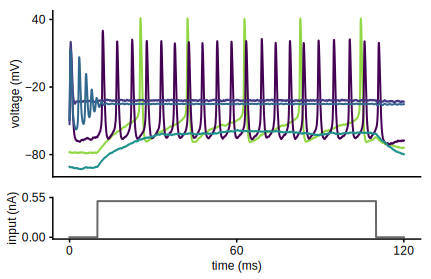

In [70]:
t = obs['time']
duration = np.max(t)

A_soma = np.pi*((70.*1e-4)**2)  # cm2

num_samp = 5
num_colors = num_samp+1
cm1 = mpl.cm.viridis
col1 = [cm1(1.*i/num_colors) for i in range(num_colors)]

# matplotlib takes figsize specified as inches
# in NIPS2016 SCALE_IN and the conversion function are defined
fig_inches = (SCALE_IN*mm2inches(0.93*ROW_1_WIDTH_COL_2_MM), SCALE_IN*mm2inches(0.93*ROW_1_HEIGHT_MM))

with mpl.rc_context(fname=MPL_RC):
    plt.figure(figsize=fig_inches)

    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    ax = plt.subplot(gs[0])

    # samples from prior
    params = p.gen(n_samples=num_samp)

    # simulation and plotting
    V = np.zeros((len(t),num_samp))
    for i in range(num_samp):
        m = HodgkinHuxley(I=I, dt=dt, seed=230+i, cython=True, prior_log=prior_log)
        x = m.gen_single(params[i,:])
        V[:,i] = x['data']
        plt.plot(t, V[:, i], color = col1[i-1], lw=2)

    plt.ylabel('voltage (mV)')
    ax.set_xticks([])
    ax.set_yticks([-80, -20, 40])

    ax = plt.subplot(gs[1])
    plt.plot(t,I*A_soma*1e3, color = COL['EFREE'], lw=2)
    plt.xlabel('time (ms)')
    plt.ylabel('input (nA)')

    ax.set_xticks([0, duration/2, duration])
    ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
    ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    
    plt.savefig(PANEL_A, facecolor=plt.gcf().get_facecolor(), transparent=True)  # the figure is saved as svg
    plt.close()

svg(PANEL_A)

## Panel B

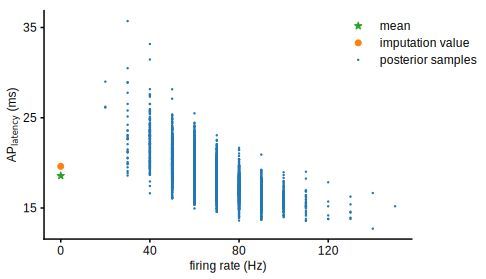

In [71]:
# matplotlib takes figsize specified as inches
# in NIPS2016 SCALE_IN and the conversion function are defined
fig_inches = (SCALE_IN*mm2inches(0.93*ROW_1_WIDTH_COL_2_MM), SCALE_IN*mm2inches(0.93*ROW_1_HEIGHT_MM))

with mpl.rc_context(fname=MPL_RC):
    
    plt.figure(figsize=fig_inches)
    ax = plt.subplot()

    # results for inference where missing features have imputed values
    out_mf = pickle.load(open('./results/mf/miss_feat_run_2_round5.pkl', 'rb'))
    res_mf = io.load('./results/mf/miss_feat_run_2_round5_res.pkl')

    imputation_values = out_mf[0][-1]['imputation_values'][-1]*res_mf.stats_std+res_mf.stats_mean

    obs_stats_round = out_mf[1][-1][1]*res_mf.stats_std+res_mf.stats_mean

    plt.plot(1e3*obs_stats_round[:,0],obs_stats_round[:,1],'.', label='posterior samples')
    plt.plot(0,imputation_values[1],'o',markersize=6, label='imputation value')
    plt.plot(0,np.nanmean(obs_stats_round[:,1]),'*',markersize=8, label='mean')

    plt.xticks(np.arange(0, max(1e3*obs_stats_round[:,0])+1, 40))
    plt.yticks([15,25,35])

    plt.xlabel('firing rate (Hz)')
    plt.ylabel(r'AP$_{latency}$ (ms)')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.2, 1), loc='upper right');

    plt.savefig(PANEL_B, facecolor=plt.gcf().get_facecolor(), transparent=True)  # the figure is saved as svg
    plt.close()

svg(PANEL_B)

## Compose figure

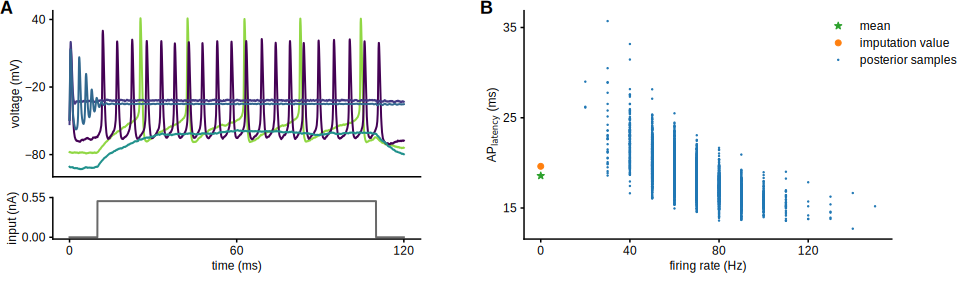

In [72]:
fig = create_fig(FIG_WIDTH_MM, FIG_HEIGHT_MM)

fig = add_svg(fig, PANEL_A, 0, 0)
fig = add_svg(fig, PANEL_B, ROW_1_WIDTH_COL_1_MM + 0, 0)

fig = add_label(fig, 'A', 0*160/2, 2.3)
fig = add_label(fig, 'B', 1*160/2, 2.3)


if False:  # set to False to disable grid
    fig = add_grid(fig, 2, 2)
    fig = add_grid(fig, 160/3, 10, font_size_px=0.0001)

PATH_SVG = PATH_DROPBOX_FIGS + 'missfeaturessupp.svg'
fig.save(PATH_SVG)

svg(PATH_SVG)

!$INKSCAPE --export-pdf $PATH_DROPBOX_FIGS/missfeaturessupp.pdf $PATH_SVG